## 4、模型训练
本节介绍使用python标准库、numpy库基于mnist数据集训练一个两层全连接神经网络（fully-connected network）完成手写字符体的识别。

回顾mindspore训练模型的过程，通常包括以下几步：

1. 加载数据，将训练集转成模型支持的数据格式
2. 定义模型，根据需求选择合适的网络结构，包括隐藏层、激活函数、损失函数，以及权重初始化、优化方法等
3. 梯度计算，正向传播将数据一层层往下传播计算损失函数的输出，再反向传播计算损失函数关于各个权重参数的梯度
4. 参数更新，也叫优化方法，最基础的方法是随机梯度下降（SGD），将权重参数沿梯度方向进行微小的更新
5. 重复前面的步骤，直到训练指标如训练次数epoch、训练精度accuracy和loss达到可以接受的值

### 4.1 加载数据

函数`load_mnist`的实现过程如下：先判断本地是否有原始的mnist压缩包，没有则从网上下载，有就直接以二进制形式读取，然后转成numpy数组，存入dict。`init_mnist`函数将解析后的dict直接序列化成mnist.pkl文件，下次加载的时候直接从pkl文件读取，免去了中间的各种操作，更简洁高效。

原始的mnist单张图片是28*28的灰度图，`load_mnist`函数支持如下处理：

1. normalize : 将图像的像素值正规化为0.0~1.0
2. one_hot_label : 标签lable默认是类别对应的数值即0-9，one_hot_label为True的情况下，标签作为one-hot数组返回即[0,0,1,0,0,0,0,0,0,0]的形式，长度为10，对应数值的位置为1，其他值为0。
3. flatten : 是否将图像展开为一维数组，展开图片会从28*28的二维数组变为784大小的一维数组，若输入层后面接的是全连接层则需要展开，若输入层后面接卷积层则不展开。

true lable: 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


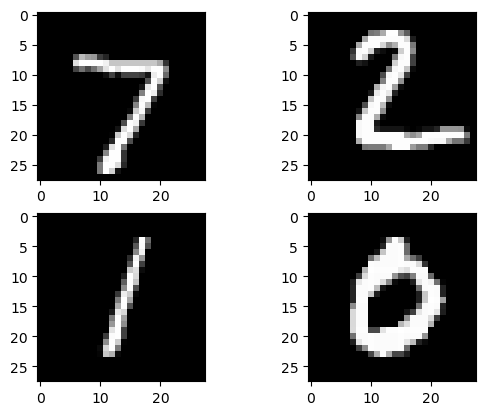

In [4]:
%reload_ext autoreload
%autoreload 2
from src.dataset.mnist import load_mnist
import matplotlib.pyplot as plt 
import numpy as np

# 返回(训练图像, 训练标签), (测试图像, 测试标签)，可打印对应的shape查看数据维度
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# 显示测试集前4张图片内容及真实标签
np.set_printoptions(threshold=np.inf)   # 完整输出矩阵的内容
print('true lable: ')
print(t_test[0:4])    # 独热码的形式
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.imshow(x_test[0].reshape(28,28), cmap ='gray')
ax2.imshow(x_test[1].reshape(28,28), cmap ='gray')
ax3.imshow(x_test[2].reshape(28,28), cmap ='gray')
ax4.imshow(x_test[3].reshape(28,28), cmap ='gray')
plt.show()

### 4.2 定义模型

本节实验用的`src/two_layer_net.py`中的2层全连接神经网络`TwoLayerNet`模型，具有2个层隐藏层，对应的权重矩阵分别是W1、W2，偏置向量分别是b1、b2，其中权重矩阵W1的行数与输入数据相等，因单张图片展平后是784，所以input_size设为784，输出层权重矩阵W2的列数与数据集中的类别数相等。激活函数使用sigmoid，损失函数使用交叉熵损失函数，在交叉上损失函数之前使用softmax做归一化处理。

`TwoLayerNet`用到的src/util.py中的`sigmoid`、`sigmoid_grad`、`softmax`三个函数需要大家补充实现，实现后运行以下测试，如果误差在允许范围内10^-5以下则实现正确。

sigmoid check error:  [1.36999512e-09 1.36999512e-09 2.02211770e-09]
sigmoid gradient array check error: [1.01460507e-12 1.76095249e-12 1.05512821e-13]
sigmoid gradient check error: 5.893741050755352e-11
softmax check error: [3.29554753e-09 2.93507391e-09 3.76937859e-09]
softmax result sum: 1.0
batch softmax check error: [[3.29554753e-09 2.93507391e-09 3.76937859e-09]
 [4.54276600e-09 1.13362886e-09 4.32360514e-09]
 [2.38808343e-09 4.01977651e-09 1.63169295e-09]]
batch softmax result sum: [1. 1. 1.]


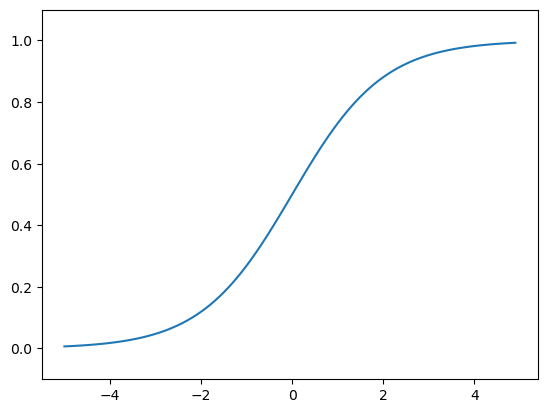

In [5]:
from src.util import sigmoid, sigmoid_grad, numerical_gradient, softmax, eval_numerical_gradient_array
x = np.array([-1.0, 1.0, 2.0])

# sigmoid函数结果校验
ref_res = [0.26894142, 0.73105858, 0.88079708]
sigmoid_err = np.abs(ref_res - sigmoid(x))
print('sigmoid check error: ', sigmoid_err)

# sigmoid梯度结果校验，对向量求导
x = np.array([-1.0, 1.0, 2.0])
ref_grad = eval_numerical_gradient_array(sigmoid, x, 1)
back_grad = sigmoid_grad(x)
grad_err =  np.abs(ref_grad - back_grad)
print('sigmoid gradient array check error:', grad_err)

# sigmoid梯度结果校验，对标量求导
x = np.array(1.0)
ref_grad = numerical_gradient(sigmoid, x)
back_grad = sigmoid_grad(x)
grad_err =  np.abs(ref_grad - back_grad)
print('sigmoid gradient check error:', grad_err)

# sofmax结果校验
a = np.array([0.3, 2.9, 4.0])
y = softmax(a)
ref_y = [0.01821127, 0.24519181, 0.73659691]
softmax_err = np.abs(ref_y - y)
sum_y = np.sum(y)
print('softmax check error:', softmax_err)
print('softmax result sum:', sum_y)

# sofmax结果校验，多个样本
a = np.array([[0.3, 2.9, 4.0],
            [-0.2, 1.5, 3.0],
            [1.2, 2.3, 1.0]])
y = softmax(a)
ref_y = [[0.01821127, 0.24519181, 0.73659691],
         [0.03225133, 0.17654206, 0.79120662],
         [0.20734427, 0.6228966,  0.16975913]]
softmax_err = np.abs(ref_y - y)
sum_y = np.sum(y, axis=1)
print('batch softmax check error:', softmax_err)
print('batch softmax result sum:', sum_y)

# sigmoid函数曲线
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(-5.0, 5.0, 0.1)
y = sigmoid(x)
plt.plot(x, y)
plt.ylim(-0.1, 1.1) # 指定y轴的范围
plt.show()

### 4.3 梯度计算

通常使用自动微分技术求解损失函数关于权重的梯度。代码中给出了数值微分`numerical_gradient`函数和基于反向传播的梯度计算`gradient`函数，完成sigmoid，sigmoid_grad，softmax三个函数就能进行模型训练。

数值微分可用于校验反向传播微分的结果是否正确，运行以下代码，对比模型的反向传播结果是否在误差范围内。误差越小越小好，通常要求小于10^-5。

In [6]:

import numpy as np
from src.dataset.mnist import load_mnist
from src.two_layer_net import TwoLayerNet

# 读入数据
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
x_batch = x_train[0:3]
t_batch = t_train[0:3]


grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average( np.abs(grad_backprop[key] - grad_numerical[key]) )
    print(key + ":" + str(diff))

W1:1.8729867706777943e-10
b1:9.0475489877514e-10
W2:7.056855300939524e-08
b2:1.4071617296523842e-07


### 4.4 参数更新

使用梯度下降更新模型参数在实现的时候有下面三种：
1. 梯度下降：是把神经网络在所有训练数据的损失都算出来，然后计算梯度再进行权重更新，通常训练数据比较大，计算比较费时，学习慢，很少直接用于深度学习。
2. 随机梯度下降：一次随机将一张图片送入到神经网络进行计算，在计算梯度再进行权重更新，不能充分利用现代CPU或者GPU的并行计算性能。
3. 小批量随机梯度下降（mini-batch）：是上面两种的折中，从全部训练的样本中选择一小批（batch）送入神经网络进行计算，计算后即更新参数，batch大小的选择则根据经验，对于分类任务，通常不超过类别数的10倍。

三种方式梯度更新时都是以下公式，只是梯度grad的计算有区别，分别是全部样本、一个样本、一批样本。

params -= learning_rate * grad

### 4.5 模型训练
`src/train_fcnet.py` 代码给出了训练一个模型的完整过程，除了以上基本步骤外，通常还会计算并输出模型在训练集上的accuracy、损失函数的输出loss。如果用了测试集，也会计算并输出测试集上loss、accuracy。

运行 `python src/train_fcnet.py` 完成模型的训练，会输出训练日志。

In [7]:
%matplotlib inline
!cd src && python train_fcnet.py

train size 60000
epoch 0 train acc: 0.1109, test acc: 0.1116
epoch 1 train acc: 0.1124, test acc: 0.1135
epoch 2 train acc: 0.1179, test acc: 0.1198
epoch 3 train acc: 0.2987, test acc: 0.3011
epoch 4 train acc: 0.4222, test acc: 0.4176
gradient compute time:  3.599548816680908 s
predict label:  [7 2 1 0] true label [7 2 1 0]
Figure(640x480)


本节需要完成的：
1. 完成src/util.py中sigmoid，sigmoid_grad，softmax三个函数的实现通过3.2代码块的测试，需在实验报告中给出sigmoid函数的基于计算图的反向传播推导过程。
2. python train_fcnet.py训练结果要求test acc达到90%以上，可以调整超参数。